<a href="https://colab.research.google.com/github/Liang130520/Deep_Learning/blob/main/%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92_transfer_learning_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!nvidia-smi

Wed Nov 23 01:57:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |    566MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [12]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224
IMG_H = 200
IMG_W = 300

In [13]:
# download from google drive or upload file by yourself
# !gdown --fuzzy '1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4' --output retina-dataset.zip

In [14]:
# unzip dataset file
# !unzip -q retina-dataset.zip

#### Data Visualization

In [15]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

In [16]:
idx = np.random.randint(0, len(paths), size=1)[0]

retina-train/16660_left_0.jpeg


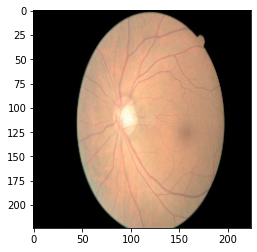

In [17]:

path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'

img = cv2.imread(path)
# (H, W, C) C: BGR -> RGB
img = img[:, :, ::-1]
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
print(path)

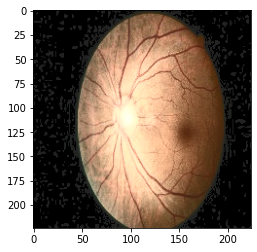

In [18]:
# Histogram Equalization
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel.
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)

In [19]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])

all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~2
print(all_cls[:3])

['38186_right_2.jpeg', '13125_right_1.jpeg', '43660_right_0.jpeg']
[2, 1, 0]


<BarContainer object of 3 artists>

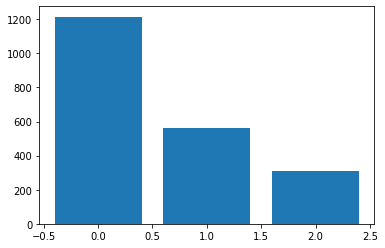

In [20]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [21]:
# clear graph
tf.keras.backend.clear_session()

In [22]:
base_model = tf.keras.applications.ResNet50(# include 代表要不要使用分類器,
                                            include_top=False, 
                                            weights='imagenet',
                                            #   weights=None, 
                                            input_shape=(224, 224, 3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [23]:
# Method 1: 
# encoder, backbone
encoder = tf.keras.applications.EfficientNetB0(include_top=False, 
                                            # weights='imagenet',
                                            weights=None, 
                                            input_shape=(IMG_H, IMG_W, 3))
x = encoder.output
# ============= classifier
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Freeeze layers
for l in encoder.layers[:]:
    l.trainable = False

model = models.Model(encoder.input, predictions)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 200, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 301, 3)  0           ['normalization[0][0]']      

In [25]:
# Method 2:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax'),
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24,113,027
Trainable params: 24,059,907
Non-trainable params: 53,120
_______________________________________

In [27]:
# Method 3:
class CNN(models.Model):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.pooling = layers.GlobalAveragePooling2D()
        self.classifier = models.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(3, activation='softmax'),
        ])
    def call(self, x):
        x = self.encoder(x)
        x = self.pooling(x)
        return self.classifier(x)

encoder = tf.keras.applications.ResNet50(include_top=False,
                                         weights='imagenet')
model = CNN(encoder)

In [28]:
model.summary()

# EfficientNetB0
# Total params: 4,444,070
# Trainable params: 4,402,047
# Non-trainable params: 42,023

# Total params: 4,444,070
# Trainable params: 394,499, 為自己寫的可訓練資料, 定義原 transfer 資料為不可訓練資料
# Non-trainable params: 4,049,571

ValueError: ignored

In [29]:
# Model 2: Extract features from an arbitrary intermediate layer with EfficientNet
base_model = tf.keras.applications.EfficientNetB0(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

# get layer by name (只要取到某層name以前的 model)
features = base_model.get_layer('block2a_expand_conv').output
# get layer by layer index
# features = base_model.layers[17].output

x = layers.GlobalAveragePooling2D()(features)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = models.Model(base_model.input, predictions)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

#### Prepare Data

In [46]:
base_model = tf.keras.applications.EfficientNetB0(# include 代表要不要使用分類器,
                                            include_top=False, 
                                            weights='imagenet',
                                            #   weights=None, 
                                            input_shape=(200, 300, 3))
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax'),
])

for l in encoder.layers[:]:
    l.trainable = False

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 200, 300, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 200, 300, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [47]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [48]:
def create_dataset(paths, img_size, num_classes=num_classes, test=False):
    num_data = len(paths)
    img_h = img_size[0]
    img_w = img_size[1]
    x_data = np.empty((num_data, img_h, img_w, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:, :, ::-1] # BGR -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB

        img = cv2.resize(img, (img_w, img_h)) # x, y
        # # preprocess by histogram equlization
        # img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        # y, cr, cb = cv2.split(img_y_cr_cb)
        # # Applying equalize Hist operation on Y channel.
        # y_eq = cv2.equalizeHist(y)
        # img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        # img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)

        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        # 0~255 -> 0~1 (要知道前處理只能透過看論文或keras官方模型)
        # -1~1
        # (img-mean) / std
        img = tf.keras.applications.resnet.preprocess_input(img)
        # 
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes) # one-hot encoding
        return x_data, y_data
    else:
        return x_data

In [49]:
x_train, y_train = create_dataset(path_train, 
                                  img_size=[IMG_H, IMG_W])
x_val, y_val = create_dataset(path_val, 
                              img_size=[IMG_H, IMG_W])
x_test = create_dataset(paths_test, test=True, 
                        img_size=[IMG_H, IMG_W])

100%|██████████| 522/522 [00:01<00:00, 314.96it/s]


In [50]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 200, 300, 3), (1668, 3), (418, 200, 300, 3), (418, 3))

#### Training

In [51]:
model.compile(optimizer='adam', 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [52]:
logs = model.fit(x_train, y_train,
                batch_size=32,
                epochs=5,
                validation_data=(x_val, y_val))

Epoch 1/5
53/53 [==============================] - 36s 470ms/step - loss: 0.8726 - categorical_accuracy: 0.5935 - val_loss: 0.8813 - val_categorical_accuracy: 0.6077
Epoch 2/5
53/53 [==============================] - 22s 409ms/step - loss: 0.7068 - categorical_accuracy: 0.6871 - val_loss: 1.2878 - val_categorical_accuracy: 0.6268
Epoch 3/5
53/53 [==============================] - 22s 407ms/step - loss: 0.5893 - categorical_accuracy: 0.7410 - val_loss: 1.7874 - val_categorical_accuracy: 0.5766
Epoch 4/5
53/53 [==============================] - 21s 404ms/step - loss: 0.4891 - categorical_accuracy: 0.7998 - val_loss: 0.9410 - val_categorical_accuracy: 0.6531
Epoch 5/5
53/53 [==============================] - 21s 402ms/step - loss: 0.4237 - categorical_accuracy: 0.8285 - val_loss: 0.8960 - val_categorical_accuracy: 0.7081


#### Make Submission file

Kaggle: https://www.kaggle.com/c/diabetic-retinopathy-classification-2/leaderboard


In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df